In [1]:
import os
import zarr
import timm
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
    augmentation=True,
    slice=True,
    pre_read=True,
)

# train_nshuffle_dataset = EziiDataset(
#     exp_names=CFG.train_exp_names,
#     base_dir="../../inputs/train/",
#     particles_name=CFG.particles_name,
#     resolution=CFG.resolution,
#     zarr_type=CFG.train_zarr_types,
#     augmentation=False,
#     train=True,
# )

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    augmentation=False,
    train=True,
    slice=True,
    pre_read=True,
)

from tqdm import tqdm

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=CFG.num_workers,
)
# train_nshuffle_loader = DataLoader(
#     train_nshuffle_dataset,
#     batch_size=1,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=CFG.num_workers,
)

for data in tqdm(train_loader):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

normalized_tomogram.shape

  0%|          | 0/600 [00:02<?, ?it/s]


torch.Size([2, 16, 630, 630])

In [3]:
# from tqdm import tqdm

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=CFG.batch_size,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
# # train_nshuffle_loader = DataLoader(
# #     train_nshuffle_dataset,
# #     batch_size=1,
# #     shuffle=True,
# #     drop_last=True,
# #     pin_memory=True,
# #     num_workers=CFG.num_workers,
# # )
# valid_loader = DataLoader(
#     valid_dataset,
#     batch_size=1,
#     shuffle=False,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )

# for data in tqdm(train_loader):
#     normalized_tomogram = data["normalized_tomogram"]
#     segmentation_map = data["segmentation_map"]
#     break

# normalized_tomogram.shape

In [4]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
# model.load_state_dict(torch.load("./pretrained_model.pth"))
# model.load_state_dict(torch.load("./best_model.pth"))

In [5]:
# # "encoder"と名のつくパラメータは学習しない
# for layer, param in model.named_parameters():
#     if "encoder" in layer:
#         param.requires_grad = False

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [7]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    if random.random() < p:
        tomogram, segmentation_map = mixup(
            tomogram, segmentation_map, alpha=mixup_alpha
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 256, 256])


In [8]:
from transformers import get_cosine_schedule_with_warmup

optimizer = torch.optim.Adam(
    model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
)
criterion = nn.CrossEntropyLoss(
    #  weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=10,
    num_training_steps=CFG.epochs * len(train_loader),
    # * batch_size,
)
scaler = GradScaler()
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

In [9]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [10]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor

In [11]:
padf = PadToSize(CFG.resolution)
padf(normalized_tomogram).shape

torch.Size([2, 16, 640, 640])

In [12]:
best_model = None
best_score = -100

grand_train_loss = []
grand_valid_loss = []
grand_train_score = []
grand_valid_score = []

for epoch in range(CFG.epochs):
    model.train()
    train_loss = []
    valid_loss = []
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"]
            segmentation_map = data["segmentation_map"]

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            # データ拡張
            normalized_tomogram, segmentation_map = augment_data(
                normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
            )
            normalized_tomogram = normalized_tomogram.cuda()
            segmentation_map = segmentation_map.long().cuda()

            optimizer.zero_grad()

            with autocast():
                pred = model(preprocess_tensor(normalized_tomogram))
                loss = seg_loss(pred, segmentation_map)
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

    with tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"].cuda()
            segmentation_map = data["segmentation_map"].long().cuda()

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            pred = model(preprocess_tensor(normalized_tomogram))
            loss = seg_loss(pred, segmentation_map)
            valid_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

    # # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # モデルの保存
    torch.save(model.state_dict(), "./pretrained_model.pth")

    # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # for exp_name in tqdm(CFG.train_exp_names):
    for exp_name in CFG.train_exp_names[:5]:  # 5つのデータで試す
        # inferenced_array = inference(model, exp_name, train=False)
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=True
        )

        constant = 0.2
        sikii = {
            "apo-ferritin": constant,
            "beta-amylase": constant,
            "beta-galactosidase": constant,
            "ribosome": constant,
            "thyroglobulin": constant,
            "virus-like-particle": constant,
        }

        pred_df = inference2pos(
            pred_segmask=inferenced_array, exp_name=exp_name, sikii_dict=sikii
        )
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])

        train_nshuffle_pred_tomogram[exp_name] = inferenced_array

        if len(pred_df) != 0:
            score_ = score(
                pred_df,
                gt_df,
                row_id_column_name="index",
                distance_multiplier=1.0,
                beta=4,
            )
            train_mean_scores.append(score_)

        del inferenced_array, n_tomogram, segmentation_map
        import gc
        import torch.cuda as cuda

        gc.collect()
        cuda.empty_cache()

    # print("train_mean_scores", np.mean(train_mean_scores))

    for exp_name in CFG.valid_exp_names:
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=True
        )
        pred_df = inference2pos(
            pred_segmask=inferenced_array, exp_name=exp_name, sikii_dict=sikii
        )
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])

        valid_pred_tomogram[exp_name] = inferenced_array

        if len(pred_df) != 0:
            score_ = score(
                pred_df,
                gt_df,
                row_id_column_name="index",
                distance_multiplier=1.0,
                beta=4,
            )
            valid_mean_scores.append(score_)

        del inferenced_array, n_tomogram, segmentation_map
        import gc
        import torch.cuda as cuda

        gc.collect()
        cuda.empty_cache()
    # print("valid_mean_scores", np.mean(valid_mean_scores))

    if np.mean(valid_mean_scores) > best_score:
        best_score = np.mean(valid_mean_scores)
        best_model = model.state_dict()
        torch.save(best_model, f"./best_model.pth")

    print(
        f"train-epoch-loss:{np.mean(train_loss):.4f}",
        f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
        f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
        f"valid-beta4-score:{np.mean(valid_mean_scores):.4f}",
    )

    grand_train_loss.append(np.mean(train_loss))
    grand_valid_loss.append(np.mean(valid_loss))
    grand_train_score.append(np.mean(train_mean_scores))
    grand_valid_score.append(np.mean(valid_mean_scores))

Epoch 1/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s, loss=0.0481]


train-epoch-loss:0.3514 valid-epoch-loss:0.0481 train-beta4-score:0.1105 valid-beta4-score:0.0970


Epoch 2/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it, loss=0.0246]


train-epoch-loss:0.0328 valid-epoch-loss:0.0246 train-beta4-score:0.0857 valid-beta4-score:0.0704


Epoch 3/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it, loss=0.0105]


train-epoch-loss:0.0257 valid-epoch-loss:0.0105 train-beta4-score:0.2215 valid-beta4-score:0.1884


Epoch 4/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it, loss=0.0081]


train-epoch-loss:0.0230 valid-epoch-loss:0.0081 train-beta4-score:0.3117 valid-beta4-score:0.2653


Epoch 5/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it, loss=0.0167]


train-epoch-loss:0.0219 valid-epoch-loss:0.0167 train-beta4-score:0.3954 valid-beta4-score:0.3226


Epoch 6/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it, loss=0.0077]


train-epoch-loss:0.0192 valid-epoch-loss:0.0077 train-beta4-score:0.3524 valid-beta4-score:0.2992


Epoch 7/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it, loss=0.0204]


train-epoch-loss:0.0191 valid-epoch-loss:0.0204 train-beta4-score:0.4921 valid-beta4-score:0.2833


Epoch 8/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, loss=0.0166]


train-epoch-loss:0.0203 valid-epoch-loss:0.0166 train-beta4-score:0.4229 valid-beta4-score:0.3410


Epoch 9/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it, loss=0.0211]


train-epoch-loss:0.0188 valid-epoch-loss:0.0211 train-beta4-score:0.3931 valid-beta4-score:0.3103


Epoch 10/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it, loss=0.0038]


train-epoch-loss:0.0181 valid-epoch-loss:0.0038 train-beta4-score:0.5767 valid-beta4-score:0.4171


Epoch 11/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it, loss=0.0003]


train-epoch-loss:0.0159 valid-epoch-loss:0.0003 train-beta4-score:0.4826 valid-beta4-score:0.4139


Epoch 12/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it, loss=0.0018]


train-epoch-loss:0.0179 valid-epoch-loss:0.0018 train-beta4-score:0.7095 valid-beta4-score:0.5720


Epoch 13/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it, loss=0.0032]


train-epoch-loss:0.0157 valid-epoch-loss:0.0032 train-beta4-score:0.5069 valid-beta4-score:0.4128


Epoch 14/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it, loss=0.0171]


train-epoch-loss:0.0178 valid-epoch-loss:0.0171 train-beta4-score:0.5888 valid-beta4-score:0.4741


Epoch 15/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, loss=0.0061]


train-epoch-loss:0.0156 valid-epoch-loss:0.0061 train-beta4-score:0.6446 valid-beta4-score:0.4689


Epoch 16/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, loss=0.0146]


train-epoch-loss:0.0142 valid-epoch-loss:0.0146 train-beta4-score:0.6975 valid-beta4-score:0.5675


Epoch 17/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, loss=0.0204]


train-epoch-loss:0.0159 valid-epoch-loss:0.0204 train-beta4-score:0.6899 valid-beta4-score:0.5393


Epoch 18/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, loss=0.0002]


train-epoch-loss:0.0152 valid-epoch-loss:0.0002 train-beta4-score:0.5397 valid-beta4-score:0.4286


Epoch 19/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, loss=0.0130]


train-epoch-loss:0.0141 valid-epoch-loss:0.0130 train-beta4-score:0.5682 valid-beta4-score:0.4263


Epoch 20/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, loss=0.0100]


train-epoch-loss:0.0141 valid-epoch-loss:0.0100 train-beta4-score:0.6502 valid-beta4-score:0.4647


Epoch 21/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, loss=0.0211]


train-epoch-loss:0.0150 valid-epoch-loss:0.0211 train-beta4-score:0.7446 valid-beta4-score:0.5377


Epoch 22/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it, loss=0.0123]


train-epoch-loss:0.0135 valid-epoch-loss:0.0123 train-beta4-score:0.6028 valid-beta4-score:0.5051


Epoch 23/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, loss=0.0149]


train-epoch-loss:0.0131 valid-epoch-loss:0.0149 train-beta4-score:0.5979 valid-beta4-score:0.4264


Epoch 24/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, loss=0.0126]


train-epoch-loss:0.0132 valid-epoch-loss:0.0126 train-beta4-score:0.6559 valid-beta4-score:0.4823


Epoch 25/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, loss=0.0202]


train-epoch-loss:0.0128 valid-epoch-loss:0.0202 train-beta4-score:0.6325 valid-beta4-score:0.4879


Epoch 26/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, loss=0.0065]


train-epoch-loss:0.0132 valid-epoch-loss:0.0065 train-beta4-score:0.6003 valid-beta4-score:0.4882


Epoch 27/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, loss=0.0176]


train-epoch-loss:0.0137 valid-epoch-loss:0.0176 train-beta4-score:0.6279 valid-beta4-score:0.5243


Epoch 28/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, loss=0.0197]


train-epoch-loss:0.0132 valid-epoch-loss:0.0197 train-beta4-score:0.6522 valid-beta4-score:0.4807


Epoch 29/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, loss=0.0021]


train-epoch-loss:0.0137 valid-epoch-loss:0.0021 train-beta4-score:0.6760 valid-beta4-score:0.5398


Epoch 30/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, loss=0.0183]


train-epoch-loss:0.0134 valid-epoch-loss:0.0183 train-beta4-score:0.6387 valid-beta4-score:0.4511


Epoch 31/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, loss=0.0196]


train-epoch-loss:0.0135 valid-epoch-loss:0.0196 train-beta4-score:0.7668 valid-beta4-score:0.5694


Epoch 32/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it, loss=0.0264]


train-epoch-loss:0.0114 valid-epoch-loss:0.0264 train-beta4-score:0.7980 valid-beta4-score:0.5374


Epoch 33/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, loss=0.0003]


train-epoch-loss:0.0125 valid-epoch-loss:0.0003 train-beta4-score:0.6921 valid-beta4-score:0.4995


Epoch 34/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, loss=0.0213]


train-epoch-loss:0.0118 valid-epoch-loss:0.0213 train-beta4-score:0.6811 valid-beta4-score:0.4795


Epoch 35/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it, loss=0.0142]


train-epoch-loss:0.0120 valid-epoch-loss:0.0142 train-beta4-score:0.5250 valid-beta4-score:0.3682


Epoch 36/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, loss=0.0011]


train-epoch-loss:0.0119 valid-epoch-loss:0.0011 train-beta4-score:0.5867 valid-beta4-score:0.4326


Epoch 37/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, loss=0.0268]


train-epoch-loss:0.0116 valid-epoch-loss:0.0268 train-beta4-score:0.6613 valid-beta4-score:0.5294


Epoch 38/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, loss=0.0003]


train-epoch-loss:0.0117 valid-epoch-loss:0.0003 train-beta4-score:0.5197 valid-beta4-score:0.4551


Epoch 39/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, loss=0.0076]


train-epoch-loss:0.0104 valid-epoch-loss:0.0076 train-beta4-score:0.6667 valid-beta4-score:0.5160


Epoch 40/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, loss=0.0207]


train-epoch-loss:0.0111 valid-epoch-loss:0.0207 train-beta4-score:0.5778 valid-beta4-score:0.4695


Epoch 41/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, loss=0.0006]


train-epoch-loss:0.0108 valid-epoch-loss:0.0006 train-beta4-score:0.6833 valid-beta4-score:0.4970


Epoch 42/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, loss=0.0141]


train-epoch-loss:0.0111 valid-epoch-loss:0.0141 train-beta4-score:0.5942 valid-beta4-score:0.4557


Epoch 43/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, loss=0.0213]


train-epoch-loss:0.0102 valid-epoch-loss:0.0213 train-beta4-score:0.5890 valid-beta4-score:0.3996


Epoch 44/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, loss=0.0001]


train-epoch-loss:0.0111 valid-epoch-loss:0.0001 train-beta4-score:0.6091 valid-beta4-score:0.4929


Epoch 45/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it, loss=0.0092]


train-epoch-loss:0.0112 valid-epoch-loss:0.0092 train-beta4-score:0.5022 valid-beta4-score:0.4773


Epoch 46/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, loss=0.0198]


train-epoch-loss:0.0106 valid-epoch-loss:0.0198 train-beta4-score:0.4581 valid-beta4-score:0.4062


Epoch 47/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, loss=0.0215]


train-epoch-loss:0.0096 valid-epoch-loss:0.0215 train-beta4-score:0.5604 valid-beta4-score:0.4368


Epoch 48/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, loss=0.0202]


train-epoch-loss:0.0098 valid-epoch-loss:0.0202 train-beta4-score:0.7109 valid-beta4-score:0.4263


Epoch 49/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it, loss=0.0014]


train-epoch-loss:0.0097 valid-epoch-loss:0.0014 train-beta4-score:0.5724 valid-beta4-score:0.4382


Epoch 50/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, loss=0.0014]


train-epoch-loss:0.0102 valid-epoch-loss:0.0014 train-beta4-score:0.8352 valid-beta4-score:0.5705


Epoch 51/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, loss=0.0227]


train-epoch-loss:0.0103 valid-epoch-loss:0.0227 train-beta4-score:0.5510 valid-beta4-score:0.4771


Epoch 52/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, loss=0.0269]


train-epoch-loss:0.0093 valid-epoch-loss:0.0269 train-beta4-score:0.5300 valid-beta4-score:0.4340


Epoch 53/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, loss=0.0244]


train-epoch-loss:0.0106 valid-epoch-loss:0.0244 train-beta4-score:0.6036 valid-beta4-score:0.4719


Epoch 54/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, loss=0.0033]


train-epoch-loss:0.0094 valid-epoch-loss:0.0033 train-beta4-score:0.5175 valid-beta4-score:0.4236


Epoch 55/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, loss=0.0232]


train-epoch-loss:0.0097 valid-epoch-loss:0.0232 train-beta4-score:0.5812 valid-beta4-score:0.4502


Epoch 56/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, loss=0.0261]


train-epoch-loss:0.0089 valid-epoch-loss:0.0261 train-beta4-score:0.8587 valid-beta4-score:0.5741


Epoch 57/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, loss=0.0190]


train-epoch-loss:0.0093 valid-epoch-loss:0.0190 train-beta4-score:0.6473 valid-beta4-score:0.4998


Epoch 58/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it, loss=0.0016]


train-epoch-loss:0.0090 valid-epoch-loss:0.0016 train-beta4-score:0.7528 valid-beta4-score:0.4622


Epoch 59/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, loss=0.0186]


train-epoch-loss:0.0098 valid-epoch-loss:0.0186 train-beta4-score:0.5731 valid-beta4-score:0.4625


Epoch 60/80 [Validation]: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it, loss=0.0081]


train-epoch-loss:0.0094 valid-epoch-loss:0.0081 train-beta4-score:0.5524 valid-beta4-score:0.4650


Epoch 61/80 [Training]:  20%|██        | 121/600 [01:18<05:11,  1.54it/s, loss=0.0087]


KeyboardInterrupt: 

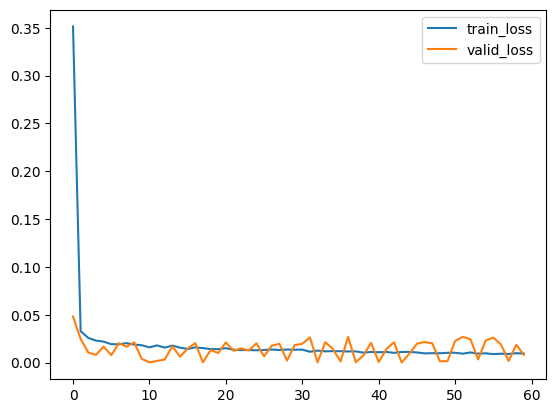

In [13]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

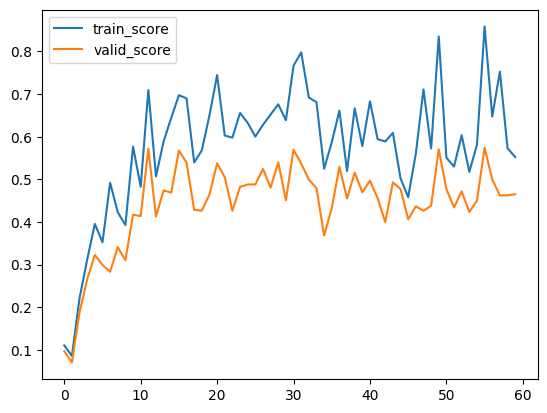

In [14]:
# train_scoreとvalid_scoreのプロット
plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [15]:
random.random()

0.6346585498484996